In [1]:
import sympy
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
sympy.init_printing()

In [2]:
omega, v = sympy.symbols('omega, v', real=True) # lie algebra for dynamics
theta, x_1, x_2 = sympy.symbols('theta, x^1, x^2', real=True) # lie group parameterization
alpha, u_1, u_2 = sympy.symbols('alpha, u^1, u^2', real=True) # lie algebra parameterization

In [3]:
E = [sympy.Matrix([
    [0, -1, 0],
    [1, 0, 0],
    [0, 0, 0]]),
    sympy.Matrix([
    [0, 0, 1],
    [0, 0, 0],
    [0, 0, 0]]),
    sympy.Matrix([
    [0, 0, 0],
    [0, 0, 1],
    [0, 0, 0]])]

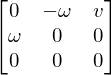

In [4]:
nu = E[0]*omega + E[1]*v
chi = E[0]*alpha + E[1]*u_1 + E[2]*u_2
nu

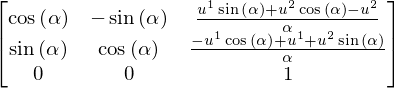

In [5]:
eta = sympy.exp(chi).simplify()
eta

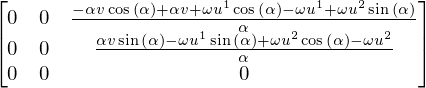

In [6]:
M = (nu - eta.inv()*nu*eta).simplify()
M

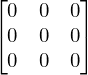

In [7]:
M.applyfunc(lambda e: e.limit(alpha, 0).limit(u_1, 0).limit(u_2, 0))

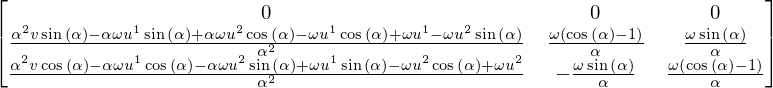

In [8]:
X = sympy.Matrix([alpha, u_1, u_2])
Y = sympy.Matrix([M[1, 0], M[0, 2], M[1, 2]])
J = Y.jacobian(X).applyfunc(lambda e: e.simplify())
J

Near the origin, zero error, this looks like the adjoint matrix.

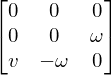

In [9]:
A = J.applyfunc(lambda e: e.limit(alpha, 0).limit(u_1, 0).limit(u_2, 0))
A 

Need to bound the matrix around the origin by looking at multidimensional taylor series residual.

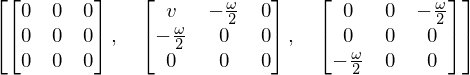

In [10]:
H = [sympy.Matrix.zeros(3, 3), sympy.Matrix.zeros(3, 3), sympy.Matrix.zeros(3, 3)]
for k in range(3):
    for i in range(3):
        for j in range(3):
            H[k][i, j] = Y[k].diff(X[i]).diff(X[j]).limit(alpha, 0).limit(u_1, 0).limit(u_2, 0)
H

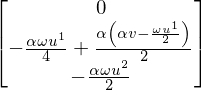

In [11]:
R = sympy.Matrix([X.T*H[0]*X, X.T*H[1]*X, X.T*H[2]*X])/2
R

Now we need to find the max and min value of this residual over x, y, theta within a fixed range, set by the lyapunov function.

In [12]:
sympy.solve(R[1].diff(X), X)

In [13]:
sympy.solve(R[2].diff(X), X)

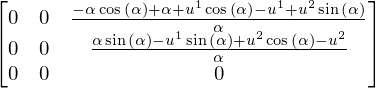

In [14]:
M.subs({omega: 1, v: 1})

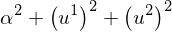

In [15]:
P = sympy.Matrix.diag([1, 1, 1])
P
V = (X.T*P*X)[0]
V

In [16]:
c = sympy.symbols('c', positive=True)

In [17]:
lam = sympy.symbols('lambda', nonzero=True)

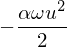

In [18]:
R[2]

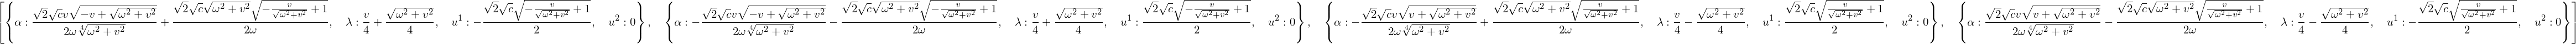

In [19]:
L1 = R[1] - lam*(V - c)
sol_L1 = sympy.solve(L1.diff(sympy.Matrix([alpha, u_1, u_2, lam])), [lam, alpha, u_1, u_2], dict=True)
for i, s in enumerate(sol_L1):
    for k in s.keys():
        sol_L1[i][k] = s[k].expand()
sol_L1

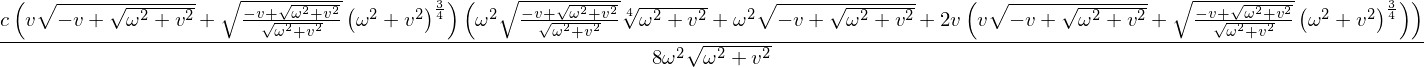

In [20]:
R[1].subs(sol_L1[0]).simplify()

In [21]:
for i in range(4):
    print(sympy.N(R[1].subs(sol_L1[i]).subs({c: 1, v: 1, omega: 1})))

0.603553390593274
0.603553390593274
-0.103553390593274
-0.103553390593274


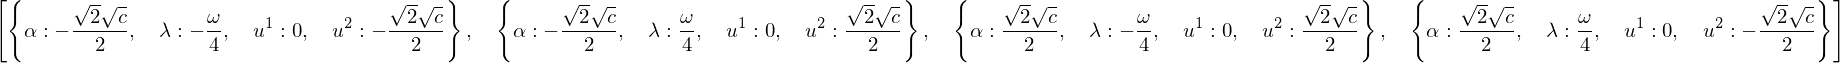

In [22]:
L2 = R[2] - lam*(V - c)
sol_L2 = sympy.solve(L2.diff(sympy.Matrix([alpha, u_1, u_2, lam])), [lam, alpha, u_1, u_2], dict=True)
for i, s in enumerate(sol_L2):
    for k in s.keys():
        sol_L2[i][k] = s[k].expand()
sol_L2

In [23]:
for i in range(4):
    print(sympy.N(R[2].subs(sol_L2[i]).subs({c: 1, v: 1, omega: 1})))

-0.250000000000000
0.250000000000000
-0.250000000000000
0.250000000000000


In [24]:
def simulation(x0, tf=5, dt_control=0.1, dt=0.01):

    def f(t, x, u):
        omega = u[0]
        v = u[1]
        dx = np.zeros(3)
        theta = x[0]
        dx[0] = omega
        dx[1] = v*np.cos(theta)
        dx[2] = v*np.sin(theta)
        return dx

    def g(t):
        u = np.zeros(2)
        f = 1
        u[0] = 2 + 0.5*np.sin(2*np.pi*f*t)  # omega
        u[1] = 2 + np.sin(2*np.pi*f*t)  # v
        return u

    t_control = np.arange(0, tf, dt_control)

    data = {
        't': [],
        'x': [],
        'x_t': [],
        'u': []
    }
    x = x0
    x_t = [0, 0, 0]

    for t in t_control:
        u = g(t)
        t_eval = np.arange(t, t + dt_control, dt)
        sim = scipy.integrate.solve_ivp(lambda t, x: f(t, x, u), [t_eval[0], t_eval[-1]], x, t_eval=t_eval)
        x = sim.y[:, -1]

        sim_t = scipy.integrate.solve_ivp(lambda t, x: f(t, x, u), [t_eval[0], t_eval[-1]], x_t, t_eval=t_eval)
        x_t = sim_t.y[:, -1]
        
        # correction, simulate simple kalman filter
        y = x_t + 0.1*np.random.randn(3)
        K = np.diag([0.2, 0.2, 0.2])
        H = np.eye(3)
        x = K.dot(y - H.dot(x)) + x
        
        data['t'].append(sim.t)
        data['x'].append(sim.y)
        data['x_t'].append(sim_t.y)
        data['u'].append(np.array([u]).T*np.ones(len(sim.t)))


    for k in data.keys():
        data[k] = np.hstack(data[k])    
    return data

In [25]:
tf = 2
mc_data = []
for i in range(300):
    mc_data.append(simulation(x0=0.3*2*(np.random.rand(3) - 0.5), tf=tf))

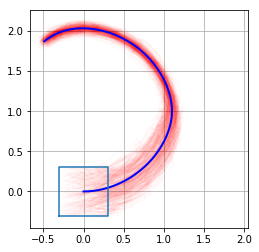

In [26]:
for d in mc_data:
    plt.plot(d['x'][1,:], d['x'][2,:], '-r', alpha=0.02)
plt.plot(mc_data[0]['x_t'][1,:], mc_data[0]['x_t'][2,:], '-b', linewidth=2)
plt.axis('square')
plt.plot(0.3*np.array([-1, 1, 1, -1, -1]), 0.3*np.array([-1, -1, 1, 1, -1]))
plt.grid()

In [27]:
import cvxpy as cvx

def find_V_alpha(A, tol=1e-5, i_max=1000):
    P = cvx.Variable(shape=A.shape, symmetric=True)
    if np.max(np.linalg.eig(A)[0]) >= 0:
        raise RuntimeError("A must be stable")
    alpha = 0
    step = 1
    i = 0
    while True:
        constraints = [
            cvx.matmul(A, P) + cvx.matmul(P, A.T) + 2*alpha*P <= 0,
            P >= np.eye(2)
        ]
        prob = cvx.Problem(cvx.Maximize(0), constraints)
        prob.solve(verbose=False)

        if prob.status == 'optimal':
            if step < tol:
                P.value = P.value / np.max(P.value)
                break
            step *= 1.9
            alpha += step
        else:
            alpha -= step
            step *= 0.4

        i += 1
        if i > i_max:
            raise RuntimeError('failed to converge')

    assert prob.status == 'optimal'
    return P.value, alpha

In [28]:
def line_search(constraints, objective=cvx.Minimize(0), direction=1, alpha_0=1e-9, tol=1e-5, i_max=100, verbose=False):
    """
    constraints: f(alpha)
    """
    step = 1
    i = 0
    alpha = alpha_0
    
    prob = cvx.Problem(objective, constraints(alpha))
    prob.solve(verbose=verbose)
    if prob.status != 'optimal':
        raise RuntimeError('initial alpha must be valid, alpha=', alpha, prob.status)
        
    while True:
        prob = cvx.Problem(objective, constraints(alpha + step))
        prob.solve(verbose=verbose)
        if prob.status == 'optimal':
            if step < tol:
                break
            alpha += step
            step *= 1.9
        else:
            step *= 0.4
        i += 1
        if i > i_max:
            raise RuntimeError('failed to converge', alpha)
        if np.abs(alpha) > 1e6:
            raise RuntimeError('alpha diverging', alpha)

    assert prob.status == 'optimal'
    return alpha

In [35]:
def prob1():
    """
    AAE 66 pg. 
    """
    A = np.array([[-1, 1], [0, -2]])
    P = cvx.Variable(shape=A.shape, PSD=True)

    alpha = line_search(
        constraints= lambda alpha: [
            P*A + A.T*P + 2*alpha*P <= 0,
            P >= np.eye(2)])
    P.value = P.value/np.max(P.value)
    print(alpha, P.value, np.linalg.eig(A))
prob1()

1.0004316575612788 [[0.48601018 0.54470088]
 [0.54470088 1.        ]] (array([-1., -2.]), array([[ 1.        , -0.70710678],
       [ 0.        ,  0.70710678]]))


In [32]:
def prob2():
    """
    AAE 666 pg. 127
    """
    A = np.array([[0, 1], [-2, -1]])
    B = np.array([[0, 1]]).T
    C = np.array([[1, 0]])
    P = cvx.Variable(shape=(2, 2), PSD=True)
    beta = cvx.Variable(nonneg=True)
    constraints= [cvx.bmat([
            [P*A + A.T*P + C.T*C, P*B],
            [B.T*P, -beta*np.eye(1)]]) << 0]
    prob = cvx.Problem(cvx.Minimize(beta), constraints)
    prob.solve(verbose=False)
    gamma = beta.value**-0.5
    print(gamma, P.value)
prob2()

1.3228753875160437 [[1.14285668 0.28571434]
 [0.28571434 0.57142842]]


In [31]:
def prob3():
    A = np.array([[0, 1], [-2, -1]])
    B = np.array([[0, 1]]).T
    C = np.array([[1, 0]])
    D = np.array([[0, 0]])
    P = cvx.Variable(shape=(2, 2), PSD=True)
    mu_1 = cvx.Variable(nonneg=True)
    mu_2 = cvx.Variable(nonneg=True)
    g = lambda alpha: [
        cvx.bmat([
            [P*A + A.T*P + alpha*P, P*B],
            [B.T*P, -alpha*mu_1*np.eye(1)]]) << 0,
        cvx.bmat([
            [C.T*C - P, C.T*D],
            [D.T*C, D.T*D - mu_2*np.eye(1)]
        ]) << 0
    ]
    alpha = line_search(
        constraints=g,
        objective=cvx.Minimize(mu_1 + mu_2),
        alpha_0=0.1)
    print('alpha', alpha, 'mu_1', mu_1.value, 'mu_2', mu_2.value, 'gamma', np.sqrt(mu_1.value + mu_2.value))
prob3()

alpha 0.9990176518936275 mu_1 292.97444048800673 mu_2 5.806107274484295e-07 gamma 17.11649616798419
